## Libraries

In [1]:
import torch, time, pandas, numpy, PIL        
import torch.nn as nn, torch.nn.functional as F, matplotlib.pyplot as plt
from torch.autograd import Variable

## Load Data

In [2]:
train_csv_path = '/kaggle/input/ssdum/SSD-UM.xlsx'
train_df = pandas.read_excel(train_csv_path)
train_df.head()

,T,So,St,Ds
0,2009-05-01 00:00:00,29.704943,36.363720,2350.102041
1,2009-05-01 01:00:00,29.704922,36.367115,2361.989796
2,2009-05-01 02:00:00,29.704878,36.370681,2373.877551
3,2009-05-01 03:00:00,29.704809,36.374422,2385.765306
4,2009-05-01 04:00:00,29.704717,36.378341,2397.602041


## Convert and Arrange Data

In [3]:
data_len = len(train_df)

sonar = numpy.zeros(data_len)
stage = numpy.zeros(data_len)
discharge = numpy.zeros(data_len)
#SSSD = numpy.zeros((4,data_len)) # [Season Sonar Stage Discharge]
season = numpy.zeros(data_len)
iter_index = 0

for row in train_df.iloc:
    time_string = str(row[0])
    #print('Total:',time_string[0:16],'Month:',time_string[5:7],'Day:',time_string[8:10],'Hour:',time_string[11:13])
    
    season_temp = (float(time_string[5:7])  +  (float(time_string[8:10])   + float(time_string[11:13])/24 ) /30  )/12
    # season = (Month +  (Day + Hour/24)/30   )/12
    
    sonar[iter_index] = (row[1]).astype(float)
    stage[iter_index] = (row[2]).astype(float)
    discharge[iter_index] = (row[3]).astype(float)
    season[iter_index] = season_temp
    
    #SSSD[:,iter_index] = [season_temp, sonar[iter_index], stage[iter_index], discharge[iter_index]]
    iter_index = iter_index + 1
    
print(sonar.shape)

(3673,)


## Plotting

[1.14155251e-04 2.28310502e-04 3.42465753e-04 ... 4.19063927e-01
 4.19178082e-01 4.19292237e-01]


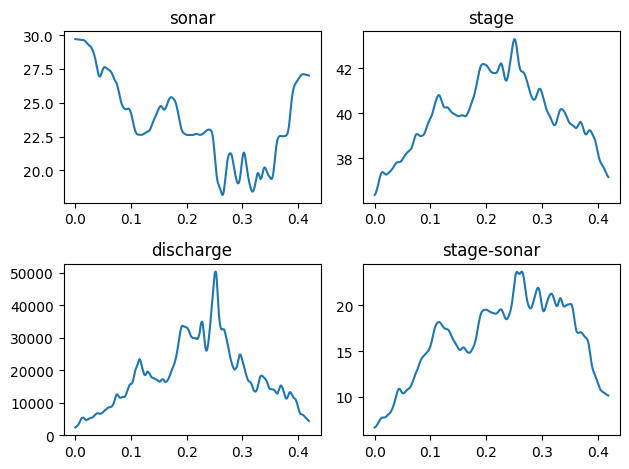

In [4]:
x_axis = numpy.linspace(1,data_len, num=data_len)/24/365 #Time in year

print(x_axis)
plt.figure(1)
plt.subplot(2,2,1)
plt.plot(x_axis,sonar)
plt.gca().set_title('sonar')
plt.subplot(2,2,2)
plt.plot(x_axis,stage)
plt.gca().set_title('stage')
plt.subplot(2,2,3)
plt.plot(x_axis,discharge)
plt.gca().set_title('discharge')
plt.subplot(2,2,4)
plt.plot(x_axis,stage-sonar)
plt.gca().set_title('stage-sonar')
plt.tight_layout()

## Scour

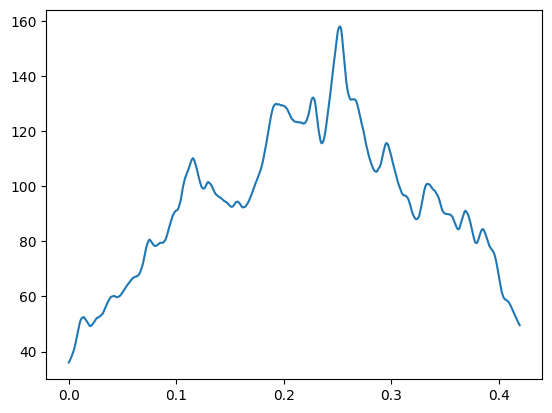

In [5]:
scour = ((stage-sonar)**0.13) * (discharge**0.43)
plt.plot(x_axis,scour)

## Data Adjustment 

### for 2-days ahead prediction 
2-days = 48 samples

### Input considerations

Season[t] Sonar[t] Stage[t] Discharge[t] Scour[t] Sonar[t-1] Stage[t-1] Discharge[t-1] Scour[t-1] Scour[t-12] Scour[t-24] Scour[t-36] Scour[t-48]

### Output
Scour[t + 48]

In [6]:
Input_ = numpy.zeros((data_len-96,3))
Output_=numpy.zeros(data_len-96)

index_last = data_len-48

for iter_index in range(48,index_last):
    
    #Input_[iter_index-48,:] = [season[iter_index], sonar[iter_index], stage[iter_index], discharge[iter_index], scour[iter_index], \
    #          sonar[iter_index-1], stage[iter_index-1], discharge[iter_index-1], scour[iter_index-1], \
    #         scour[iter_index-12], scour[iter_index-24], scour[iter_index-36], scour[iter_index-48]]
    Input_[iter_index-48,:] = [scour[iter_index], scour[iter_index-24], scour[iter_index-48]]
    
    Output_[iter_index-48] = scour[iter_index+48]
    
print(Input_.shape, Output_.shape, iter_index-48)

#plt.plot(Output_) # Checking whether data and initial dimention matches or not

(3577, 3) (3577,) 3576


In [7]:
data_len2 = len(Output_)
hr_in_4wk = 24*7*4
I_test = Input_[-hr_in_4wk-1:-1,:]
O_test = Output_[-hr_in_4wk-1:-1]

print(I_test.shape, O_test.shape, len(Output_))

Input_ = Input_[0:data_len2-hr_in_4wk,:]
Output_ = Output_[0:data_len2-hr_in_4wk]
print(Output_.shape, Input_.shape)

(672, 3) (672,) 3577
(2905,) (2905, 3)


## Normalization

In [8]:
x = torch.tensor(Input_).float()  
y = torch.tensor(Output_).float()   
new_shape = (len(y), 1)
y = y.view(new_shape)

i_val = torch.tensor(I_test).float()  
o_val = torch.tensor(O_test).float()   
new_shape = (len(o_val), 1)
o_val = o_val.view(new_shape)

max_y = torch.max(y[:,0])
min_y =torch.min(y[:,0])

max_x = torch.max(x,dim=0)
min_x = torch.min(x,dim=0)

print(max_y, min_y, max_x.values, min_x.values)

range_y = max_y - min_y
range_x = max_x.values - min_x.values

print('\n Ranges:',range_x, range_y)

    #Normalizing
x = (x - min_x.values)/range_x
y = (y - min_y)/range_y

    #Normalizing
i_val = (i_val - min_x.values)/range_x
o_val = (o_val - min_y)/range_y

num_input = len(range_x)

tensor(158.0236) tensor(49.2382) tensor([158.0236, 158.0236, 158.0236]) tensor([41.5858, 38.3179, 36.0254])

 Ranges: tensor([116.4378, 119.7058, 121.9983]) tensor(108.7855)


## Considerations

In [9]:
# Training
EPOCH_initial = 1000
EPOCH = 2000
Error_th = 1e-3
Margin =0.25

# NN
hidden =1000

# hyperparameters of cost function
alpha_ = 0.05  # capturing (1-alpha) portion of samples
delta_ = alpha_/50 # delts in loss fn
beta_1 = 1000 # PICP mismatch penalty
beta_2 = 200 # Bound swap penalty
rho_ = 1 # weight on PINAFD

## Cost function for Direct NN training

In [10]:
# define loss fn
def loss_objective(prediction, y):
    '''Loss Optimal LUBE'''
    y_u = prediction[:,0]
    y_l = prediction[:,1]
    length = len(y)
    
    pinaw = torch.mean(torch.abs(y_u-y_l))
    pinafd = torch.zeros(1)
    bsp = 0 # Bound Swap Penalty
    
    coverage_count = 0
    
    for iter1 in range(length):
        c = 0
        if y_u[iter1] < y_l[iter1]:
            bsp = bsp + torch.abs(y_l[iter1] - y_u[iter1])
        if y_u[iter1] >= y[iter1] and y_l[iter1] < y[iter1]:
            c = 1
            coverage_count = coverage_count + 1
        if c == 0:
            pinafd = pinafd + torch.min(torch.abs(y_u[iter1] - y[iter1]), torch.abs(y_l[iter1] - y[iter1]))
            # Minimum of difference becomes the failure distance
            
    pinafd = pinafd/(length - coverage_count + 1e-10)
    # 1e-10 is for avoiding the divided by zero error for 100% coverage
    picp = coverage_count/length
            
   
    Loss_S = pinaw + rho_*pinafd + beta_1*numpy.square(1-alpha_+delta_-picp) + beta_2*bsp
    
    return Loss_S

## UQ Model

In [11]:
class Net_2l(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net_2l, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.hidden2 = torch.nn.Linear(n_hidden, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
        x = F.relu(self.hidden2(x))
        x = self.predict(x)             # linear output
        return x

# use the same net as before      
net = Net_2l(n_feature=num_input, n_hidden=hidden, n_output=2)     # define the network
print(net)  # net architecture

Net_2l(
  (hidden): Linear(in_features=3, out_features=1000, bias=True)
  (hidden2): Linear(in_features=1000, out_features=1000, bias=True)
  (predict): Linear(in_features=1000, out_features=2, bias=True)
)


## Initial Training

In [12]:
y_target = torch.zeros(len(y),2)
y_target[:,0] = y[:,0] + Margin
y_target[:,1] = y[:,0] - Margin

y_t_val = torch.zeros(len(o_val),2)
y_t_val[:,0] = o_val[:,0] + Margin
y_t_val[:,1] = o_val[:,0] - Margin


optimizer = torch.optim.Adam(net.parameters(), lr=0.05)
loss_func = torch.nn.MSELoss()  # this is for regression mean squared loss

minimum_train_loss = 1e5 #High initial values
minimum_val_loss = 1e5


# start training
for epoch in range(EPOCH_initial):
  
    prediction = net(x)     # input x and predict based on x
    #print(prediction.shape, y.shape)

    loss = loss_func(prediction,y_target)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt_train = net
    
    if epoch%100 == 99:
        prediction = net_opt_train(i_val)
        loss_val = loss_func(prediction, y_t_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt_train
        
        print ("Epoch [{}/{}], "  .format(epoch+1, EPOCH_initial))
        print("Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))
        if minimum_val_loss.data.numpy() < Error_th:
            break
        
net = net_opt_val        
print("After Initial Training:  Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))


Epoch [100/1000], 
Loss: 0.0022 Minimum Loss: 0.002152 Val Loss: 0.004323
Epoch [200/1000], 
Loss: 0.0013 Minimum Loss: 0.001223 Val Loss: 0.004316
Epoch [300/1000], 
Loss: 0.0012 Minimum Loss: 0.001119 Val Loss: 0.004316
Epoch [400/1000], 
Loss: 0.0015 Minimum Loss: 0.001071 Val Loss: 0.002961
Epoch [500/1000], 
Loss: 0.0011 Minimum Loss: 0.001029 Val Loss: 0.002961
Epoch [600/1000], 
Loss: 0.001 Minimum Loss: 0.000994 Val Loss: 0.002961
Epoch [700/1000], 
Loss: 0.001 Minimum Loss: 0.000973 Val Loss: 0.002961
Epoch [800/1000], 
Loss: 0.0012 Minimum Loss: 0.000952 Val Loss: 0.002961
Epoch [900/1000], 
Loss: 0.0009 Minimum Loss: 0.000928 Val Loss: 0.002961
Epoch [1000/1000], 
Loss: 0.0009 Minimum Loss: 0.000916 Val Loss: 0.002961
After Initial Training:  Loss: 0.0009 Minimum Loss: 0.000916 Val Loss: 0.002961


Text(0.5, 1.0, 'Test Data')

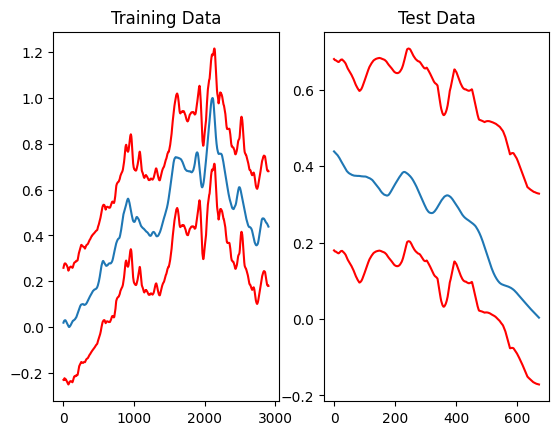

In [13]:
plt.figure(1)
plt.subplot(1,2,1)
Pred = net_opt_val(x)
plt.plot(Pred.detach().numpy(),'r')
plt.plot(y.detach().numpy())
plt.gca().set_title('Training Data')

plt.subplot(1,2,2)
plt.plot(o_val.detach().numpy())
plt.plot(net_opt_val(i_val).detach().numpy(),'r')
plt.gca().set_title('Test Data')

In [14]:
loss_func = loss_objective
optimizer = torch.optim.Adam(net.parameters(), lr=0.00005)

prediction = net_opt_val(x)
minimum_train_loss = loss_func(prediction,y) 
prediction = net_opt_val(i_val)
minimum_val_loss = loss_func(prediction,o_val) 

print("In new cost: Training Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))

# start training
for epoch in range(EPOCH):
  
    prediction = net(x)     # input x and predict based on x
    #print(prediction.shape, y.shape)

    loss = loss_func(prediction,y)     # must be (1. nn output, 2. target)

    optimizer.zero_grad()   # clear gradients for next train
    loss.backward()         # backpropagation, compute gradients
    optimizer.step()        # apply gradients
    
    if loss<minimum_train_loss:
        minimum_train_loss =loss
        net_opt_train = net
    
    if epoch%100 == 99:
        prediction = net_opt_train(i_val)
        loss_val = loss_func(prediction, o_val)
        if loss_val<minimum_val_loss:
            minimum_val_loss = loss_val
            net_opt_val = net_opt_train 
            
        if loss_val>minimum_val_loss:    # Returning to previous validation best
            net = net_opt_val
            minimum_train_loss = loss_func(net_opt_val(x),y) # Also increasing minimum train loss
        
        print ("Epoch [{}/{}], "  .format(epoch+1, EPOCH))
        print("Loss:",loss.data.numpy().round(4), "Minimum Loss:",minimum_train_loss.data.numpy().round(6),"Val Loss:",minimum_val_loss.data.numpy().round(6))

In new cost: Training Loss: [2.901968] Val Loss: [2.904094]
Epoch [100/2000], 
Loss: [1.8941] Minimum Loss: [1.865023] Val Loss: [2.904094]
Epoch [200/2000], 
Loss: [1.8649] Minimum Loss: [1.836568] Val Loss: [2.904094]
Epoch [300/2000], 
Loss: [0.8081] Minimum Loss: [0.739722] Val Loss: [2.904094]
Epoch [400/2000], 
Loss: [11.4875] Minimum Loss: [12.232582] Val Loss: [2.904094]
Epoch [500/2000], 
Loss: [2.4803] Minimum Loss: [2.649631] Val Loss: [2.904094]
Epoch [600/2000], 
Loss: [6.1066] Minimum Loss: [6.1599] Val Loss: [2.904094]
Epoch [700/2000], 
Loss: [9.1885] Minimum Loss: [9.254152] Val Loss: [2.904094]
Epoch [800/2000], 
Loss: [15.185] Minimum Loss: [15.439556] Val Loss: [2.904094]
Epoch [900/2000], 
Loss: [22.4926] Minimum Loss: [22.595652] Val Loss: [2.904094]
Epoch [1000/2000], 
Loss: [32.8413] Minimum Loss: [33.090828] Val Loss: [2.904094]
Epoch [1100/2000], 
Loss: [57.4362] Minimum Loss: [57.436157] Val Loss: [2.904094]
Epoch [1200/2000], 
Loss: [136.1654] Minimum Loss: 

Text(0.5, 1.0, 'Test Data')

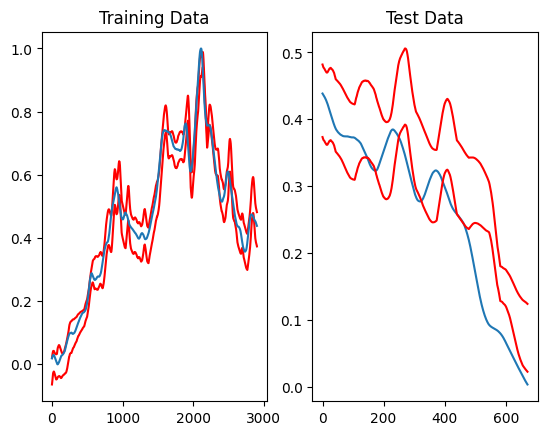

In [15]:
plt.figure(1)
plt.subplot(1,2,1)
Pred = net_opt_val(x)
plt.plot(Pred.detach().numpy(),'r')
plt.plot(y.detach().numpy())
plt.gca().set_title('Training Data')

plt.subplot(1,2,2)
plt.plot(o_val.detach().numpy())
plt.plot(net_opt_val(i_val).detach().numpy(),'r')
plt.gca().set_title('Test Data')